##Introduccion

Bitcoin (BTC) es una red de consenso, basada en la tecnología blockchain, que permite un sistema de pago y una moneda totalmente digital. Impulsado por sus usuarios, se conecta a una red de pago que no requiere una autoridad central para operar. El 31 de octubre de 2008, una persona o grupo de personas que trabajaban bajo el seudónimo "Satoshi Nakamoto" publicó el documento técnico de Bitcoin y lo describió como: "Una versión completamente peer-to-peer de efectivo electrónico, que le permite enviar pagos en línea directamente.

Dada la creciente popularidad y adopción de Bitcoin, su comportamiento resulta una motivación de analisis, es por lo que se tomara el periodo mensual más reciente, Mayo del 2021, para analisar el comportamiento del comercio de la criptomoneda lider. A través de bigQuery se tiene acceso a los datos historicos de la blockchain donde opera el intercambio de los bitcoin o en su defecto la unidad mas pequeña de un bitcoin, un satoshi que equivale a 0.000000001 Bitcoin. 

##Desarrollo

In [ ]:
#Preparación del entorno
from google.cloud import bigquery #Integración de BigQuery para conjunto de datos públicos
import pandas as pd

In [ ]:
from google.colab import auth 
auth.authenticate_user()

In [ ]:
project_id = 'certain-analyst-314001' #identificador del proyecto

client = bigquery.Client(project=project_id) #Objeto Cliente para acceder y manejar los datos.

In [ ]:
#Cargando dataset
dataset_ref = client.dataset("crypto_bitcoin", project='bigquery-public-data')
dataset = client.get_dataset(dataset_ref)

In [ ]:
#Nombre de las tablas en el dataset
tables = list(client.list_tables(dataset))

for table in tables:
  print(table.table_id)

blocks
inputs
outputs
transactions


In [ ]:
#Acceso a tabla de interes "transactions"
table_ref = dataset_ref.table('transactions')
table = client.get_table(table_ref)

In [ ]:
"""Función para estimar el tamaño de la consulta. 
Originalmente de: https://www.kaggle.com/sohier/beyond-queries-exploring-the-bigquery-api/"""
    
def estimate_gigabytes_scanned(query, bq_client):
    my_job_config = bigquery.job.QueryJobConfig() 
    my_job_config.dry_run = True 
    my_job = bq_client.query(query, job_config=my_job_config)
    
    BYTES_PER_GB = 2**30 #Bytes a Gigabytes 
    estimate = my_job.total_bytes_processed / BYTES_PER_GB
    
    print(f"{estimate} GBs.")

#StandarSQL
query_example = """
    SELECT *
    FROM `bigquery-public-data.crypto_bitcoin.transactions`
"""

estimate_gigabytes_scanned(query_example, client)

1350.1604254059494 GBs.


In [ ]:
#Consulta con datos de interes
"""
  Columnas seleccionadas de 'Transactions'
    hash: Código de la transacción. Funciona como dato no categórico (hash es una palabra clave de SQL, se coloca comillas).
    size: El tamaño de la transacción en bytes
    block_timestamp: Marca de tiempo en que el bloque, que contiene la transacción, ha sido sido minado y validado por la red blockchain.
    input_count: Cantidad de inputs que incluye la transacción
    input_value: Valor total en satoshis de las outputs de la transacción 
    output_count: Cantidad de outputs que incluye la transacción
    output_value: Valor total en satoshis de las inputs de la transacción 
  
  (1 satoshi = 0.000000001 Bitcoin)
  Periodo de tiempo de la consulta: Mayo , 2021
  
"""


query = """
    SELECT
        `hash`,
        size,
        block_timestamp,
        input_count,
        input_value,
        output_count,
        output_value
    FROM `bigquery-public-data.crypto_bitcoin.transactions`
    WHERE
        EXTRACT(YEAR FROM block_timestamp) = 2021 AND
        EXTRACT(MONTH FROM block_timestamp) = 05    
"""

estimate_gigabytes_scanned(query, client)

78.32283267378807 GBs.


In [ ]:
"""La consulta debe procesar alrededor de 79 GB de datos. Un trabajo está limitado a 
1 GB y para evitar el procesamiento accidental de demasiados datos, se pasa un parámetro de configuración de trabajo 'max_bytes' 
al inicializar un objeto QueryJobConfig de BigQuery."""

bytes_in_gigabytes = 2**30

safe_config = bigquery.QueryJobConfig(max_bytes=79 * bytes_in_gigabytes)

query_job = client.query(query, job_config=safe_config)

In [ ]:
#Creando el Data Frame con los datos recuperados
result = query_job.result()
df = result.to_dataframe()
df

,hash,size,block_timestamp,input_count,input_value,output_count,output_value
0,e29786e72cb9feee0fe2cb7347d7c195abfa3d761b237d...,293,2021-05-05 16:22:27+00:00,0,None,3,716609235
1,174983a4bacaae59a24c9b0341fbca1fac84282848843e...,296,2021-05-06 09:25:59+00:00,0,None,3,723309800
2,42a4c24af3791f58574501c58a5171ce7fbd95e4a226c4...,331,2021-05-03 13:32:16+00:00,0,None,4,741316782
3,e7c8547ed213f4485b9b70b2582cc37aa7127faef39f30...,347,2021-05-01 21:36:25+00:00,0,None,4,726586491
4,3a242ba705ec65526ade2e0c4c48e05094b79835a2b77f...,351,2021-05-02 21:11:54+00:00,0,None,4,658334236
...,...,...,...,...,...,...,...
7791606,7cb47d502a008e4faecb50ca3d5fe45c708279d6ab9e86...,416,2021-05-18 05:22:54+00:00,2,7026964,2,7021316
7791607,7f06e268befdeb6fdfa71a973b1c52ff45e14405e3a338...,416,2021-05-18 05:22:54+00:00,2,6952522,2,6946873
7791608,5f8287fdd14f35c143c66021459f5c62495200e62e5394...,416,2021-05-18 05:22:54+00:00,2,14061593,2,14055945
7791609,04759c624ada6206fc526eeecdcbc3bac21aceb1e41af5...,416,2021-05-18 05:22:54+00:00,2,5315760,2,5314994


In [ ]:
print(df['block_timestamp'].max())
print(df['block_timestamp'].min())
print()
df.dtypes

2021-05-31 23:28:19+00:00
2021-05-01 00:26:52+00:00



hash                            object
size                             int64
block_timestamp    datetime64[ns, UTC]
input_count                      int64
input_value                     object
output_count                     int64
output_value                    object
dtype: object

In [ ]:
#Columnas input_value y output_value a formato numérico

df['input_value'] = pd.to_numeric(df['input_value'])
df['output_value'] = pd.to_numeric(df['output_value'])

In [ ]:
#Nuevas columnas con el valor medio de los input y output que conforma cada transacción

df['avg_out_val'] = df['output_value'] / df['output_count']
df['avg_in_val'] = df['input_value'] / df['input_count']

In [ ]:
#Nueva columna con la comisión de cada transacción

df['fee'] = df['input_value'] - df['output_value'] 

In [ ]:
#Nueva columna con información de la comisión por byte procesado en cada transacción

df['fees_per_byte'] = df['fee'] / df['size']

In [ ]:
df

,hash,size,block_timestamp,input_count,input_value,output_count,output_value,avg_out_val,avg_in_val,fee,fees_per_byte
0,e29786e72cb9feee0fe2cb7347d7c195abfa3d761b237d...,293,2021-05-05 16:22:27+00:00,0,NaN,3,716609235.0,2.388697e+08,NaN,NaN,NaN
1,174983a4bacaae59a24c9b0341fbca1fac84282848843e...,296,2021-05-06 09:25:59+00:00,0,NaN,3,723309800.0,2.411033e+08,NaN,NaN,NaN
2,42a4c24af3791f58574501c58a5171ce7fbd95e4a226c4...,331,2021-05-03 13:32:16+00:00,0,NaN,4,741316782.0,1.853292e+08,NaN,NaN,NaN
3,e7c8547ed213f4485b9b70b2582cc37aa7127faef39f30...,347,2021-05-01 21:36:25+00:00,0,NaN,4,726586491.0,1.816466e+08,NaN,NaN,NaN
4,3a242ba705ec65526ade2e0c4c48e05094b79835a2b77f...,351,2021-05-02 21:11:54+00:00,0,NaN,4,658334236.0,1.645836e+08,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7791606,7cb47d502a008e4faecb50ca3d5fe45c708279d6ab9e86...,416,2021-05-18 05:22:54+00:00,2,7026964.0,2,7021316.0,3.510658e+06,3513482.0,5648.0,13.576923
7791607,7f06e268befdeb6fdfa71a973b1c52ff45e14405e3a338...,416,2021-05-18 05:22:54+00:00,2,6952522.0,2,6946873.0,3.473436e+06,3476261.0,5649.0,13.579327
7791608,5f8287fdd14f35c143c66021459f5c62495200e62e5394...,416,2021-05-18 05:22:54+00:00,2,14061593.0,2,14055945.0,7.027972e+06,7030796.5,5648.0,13.576923
7791609,04759c624ada6206fc526eeecdcbc3bac21aceb1e41af5...,416,2021-05-18 05:22:54+00:00,2,5315760.0,2,5314994.0,2.657497e+06,2657880.0,766.0,1.841346


In [ ]:
"""Por último se borran los registros donde input_value = 0, que corresponden a movimientos que contabilizan los nuevos bitcoin "minados" por cada bloque que se agrega a la red.
No resultan de interes para el analisis por no representar movimientos de interecambios"""

df.dropna(axis=0, subset=['input_value'], inplace=True)
df

,hash,size,block_timestamp,input_count,input_value,output_count,output_value,avg_out_val,avg_in_val,fee,fees_per_byte
12,913d23d7db88cd0ed9ff96b6ef5b8c5ccfb6cd430d6bf9...,445,2021-05-02 12:59:55+00:00,2,14000.0,2,9000.0,4.500000e+03,7000.0,5000.0,11.235955
13,806474e6df572c60e0f2689f83eda6d142a0f86c016c48...,256,2021-05-07 09:18:51+00:00,1,414780.0,3,392680.0,1.308933e+05,414780.0,22100.0,86.328125
14,64576ec5b8c5a0c0f0dc26908cc585a1aa22554aaebbd2...,256,2021-05-07 22:45:04+00:00,1,279713.0,3,257239.0,8.574633e+04,279713.0,22474.0,87.789062
15,9af384624cee303ed6cabf7086da7b9a8d91394e904713...,256,2021-05-07 09:18:51+00:00,1,369488.0,3,347388.0,1.157960e+05,369488.0,22100.0,86.328125
16,5ef59e955947857b7717ccb75110d25590b0b42e1d2fc3...,256,2021-05-07 09:07:10+00:00,1,460072.0,3,437972.0,1.459907e+05,460072.0,22100.0,86.328125
...,...,...,...,...,...,...,...,...,...,...,...
7791606,7cb47d502a008e4faecb50ca3d5fe45c708279d6ab9e86...,416,2021-05-18 05:22:54+00:00,2,7026964.0,2,7021316.0,3.510658e+06,3513482.0,5648.0,13.576923
7791607,7f06e268befdeb6fdfa71a973b1c52ff45e14405e3a338...,416,2021-05-18 05:22:54+00:00,2,6952522.0,2,6946873.0,3.473436e+06,3476261.0,5649.0,13.579327
7791608,5f8287fdd14f35c143c66021459f5c62495200e62e5394...,416,2021-05-18 05:22:54+00:00,2,14061593.0,2,14055945.0,7.027972e+06,7030796.5,5648.0,13.576923
7791609,04759c624ada6206fc526eeecdcbc3bac21aceb1e41af5...,416,2021-05-18 05:22:54+00:00,2,5315760.0,2,5314994.0,2.657497e+06,2657880.0,766.0,1.841346


In [ ]:
#Se exporta el dataframe final a un .csv

df.to_csv("transactions_202105.csv", index = False)

In [ ]:
#Lectura y uso de archivo generado 

btc = pd.read_csv('transactions_202105.csv')

In [ ]:
#Se recupera formato de fecha en columna 'block_timestamp'

btc['block_timestamp'] = pd.to_datetime(btc['block_timestamp'] )
btc

,hash,size,block_timestamp,input_count,input_value,output_count,output_value,avg_out_val,avg_in_val,fee,fees_per_byte
0,913d23d7db88cd0ed9ff96b6ef5b8c5ccfb6cd430d6bf9...,445,2021-05-02 12:59:55+00:00,2,14000.0,2,9000.0,4.500000e+03,7000.0,5000.0,11.235955
1,806474e6df572c60e0f2689f83eda6d142a0f86c016c48...,256,2021-05-07 09:18:51+00:00,1,414780.0,3,392680.0,1.308933e+05,414780.0,22100.0,86.328125
2,64576ec5b8c5a0c0f0dc26908cc585a1aa22554aaebbd2...,256,2021-05-07 22:45:04+00:00,1,279713.0,3,257239.0,8.574633e+04,279713.0,22474.0,87.789062
3,9af384624cee303ed6cabf7086da7b9a8d91394e904713...,256,2021-05-07 09:18:51+00:00,1,369488.0,3,347388.0,1.157960e+05,369488.0,22100.0,86.328125
4,5ef59e955947857b7717ccb75110d25590b0b42e1d2fc3...,256,2021-05-07 09:07:10+00:00,1,460072.0,3,437972.0,1.459907e+05,460072.0,22100.0,86.328125
...,...,...,...,...,...,...,...,...,...,...,...
7787183,7cb47d502a008e4faecb50ca3d5fe45c708279d6ab9e86...,416,2021-05-18 05:22:54+00:00,2,7026964.0,2,7021316.0,3.510658e+06,3513482.0,5648.0,13.576923
7787184,7f06e268befdeb6fdfa71a973b1c52ff45e14405e3a338...,416,2021-05-18 05:22:54+00:00,2,6952522.0,2,6946873.0,3.473436e+06,3476261.0,5649.0,13.579327
7787185,5f8287fdd14f35c143c66021459f5c62495200e62e5394...,416,2021-05-18 05:22:54+00:00,2,14061593.0,2,14055945.0,7.027972e+06,7030796.5,5648.0,13.576923
7787186,04759c624ada6206fc526eeecdcbc3bac21aceb1e41af5...,416,2021-05-18 05:22:54+00:00,2,5315760.0,2,5314994.0,2.657497e+06,2657880.0,766.0,1.841346


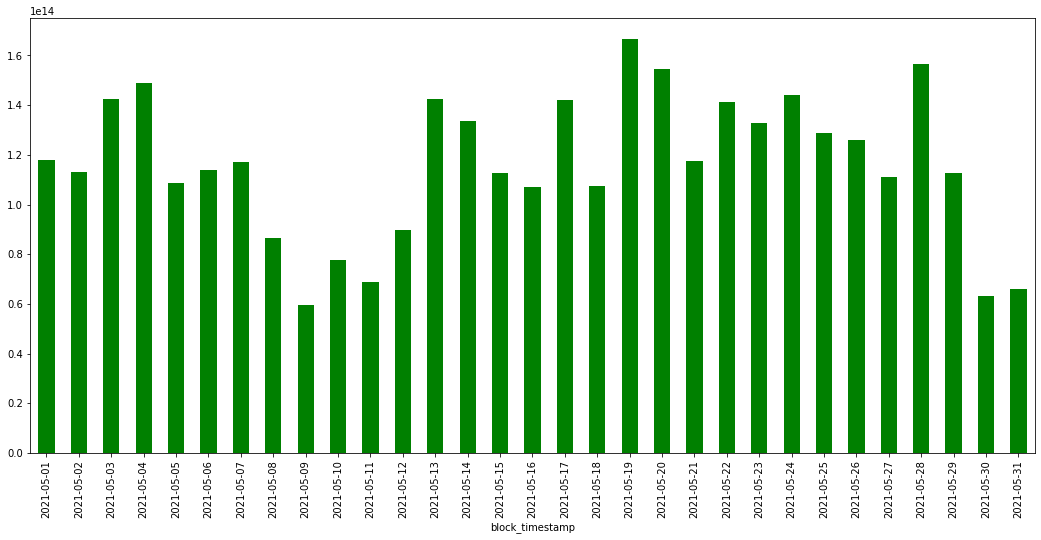

In [ ]:
btc.groupby(btc['block_timestamp'].dt.date)['avg_out_val'].sum().plot(kind='bar', figsize=(18, 8), color='green')

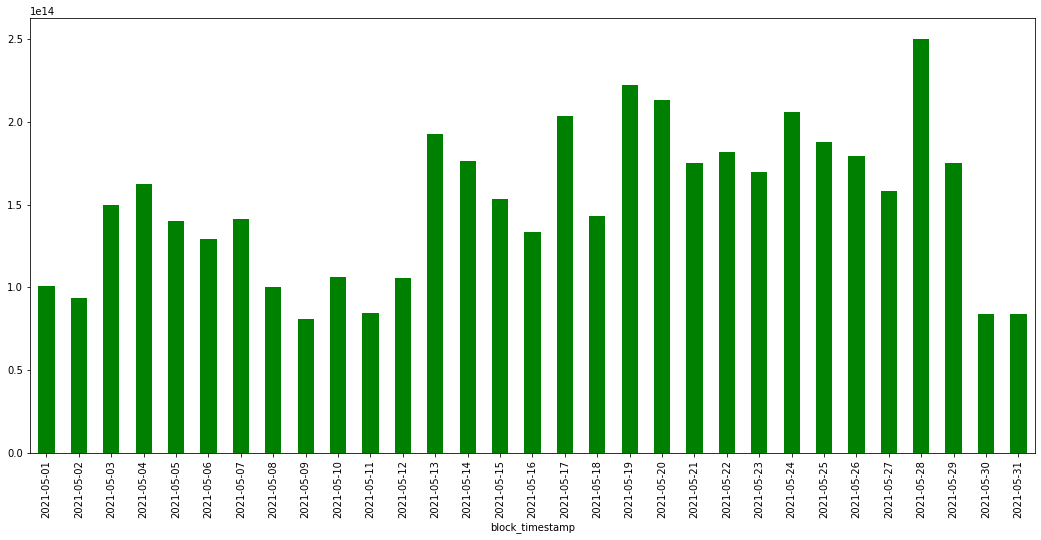

In [ ]:
btc.groupby(btc['block_timestamp'].dt.date)['avg_in_val'].sum().plot(kind='bar', figsize=(18, 8), color='green')

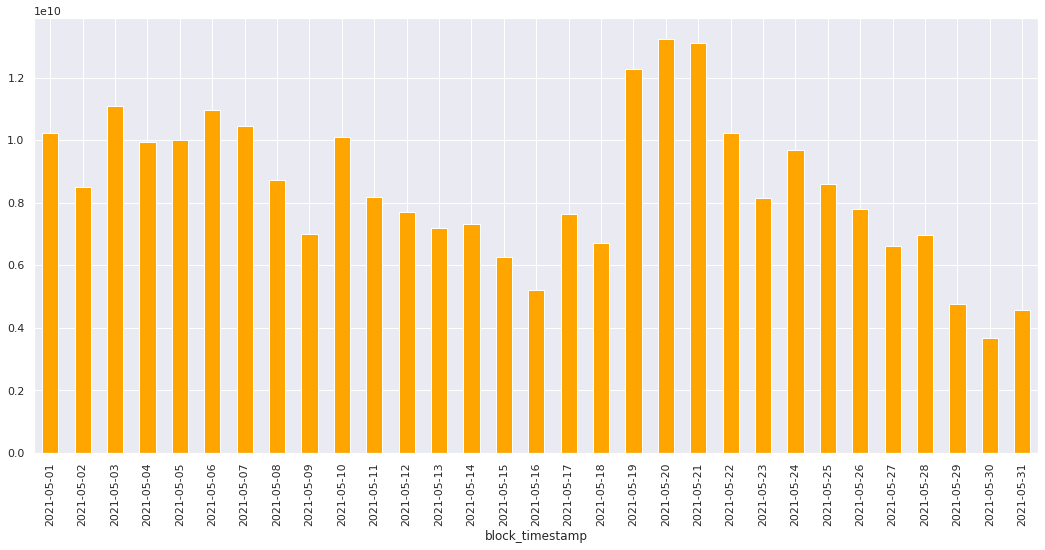

In [ ]:
btc.groupby(btc['block_timestamp'].dt.date)['fee'].sum().plot(kind='bar', figsize=(18, 8), color='orange')

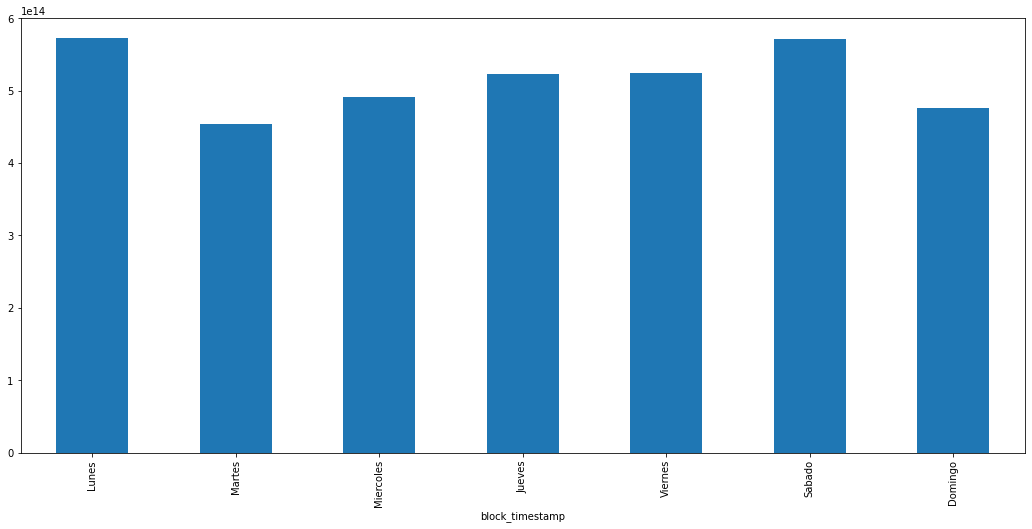

In [ ]:
(btc.groupby(btc['block_timestamp'].dt.weekday)
    ['avg_out_val'].sum()
    .rename(index={i: day for i, day in enumerate(['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'])})
    .plot(kind='bar', figsize=(18, 8)))

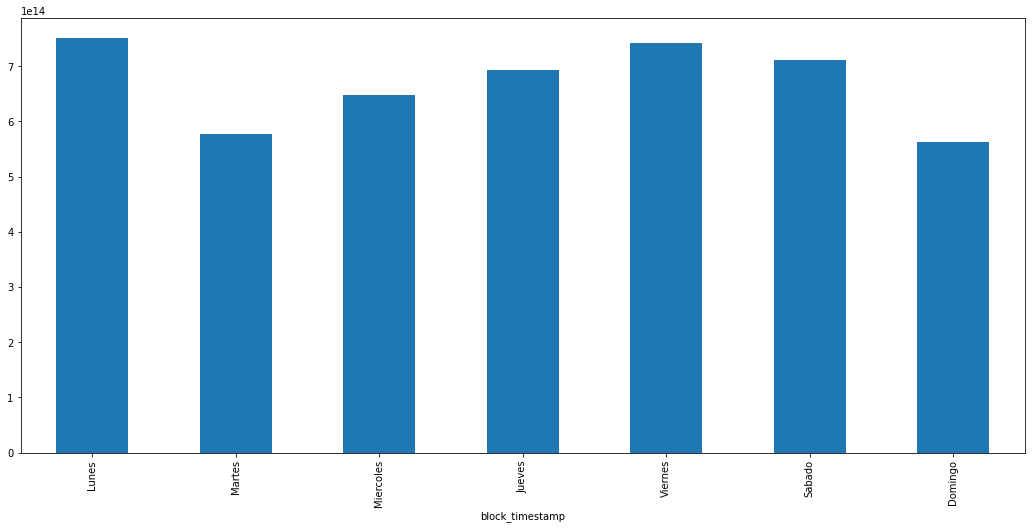

In [ ]:
(btc.groupby(btc['block_timestamp'].dt.weekday)
    ['avg_in_val'].sum()
    .rename(index={i: day for i, day in enumerate(['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'])})
    .plot(kind='bar', figsize=(18, 8)))

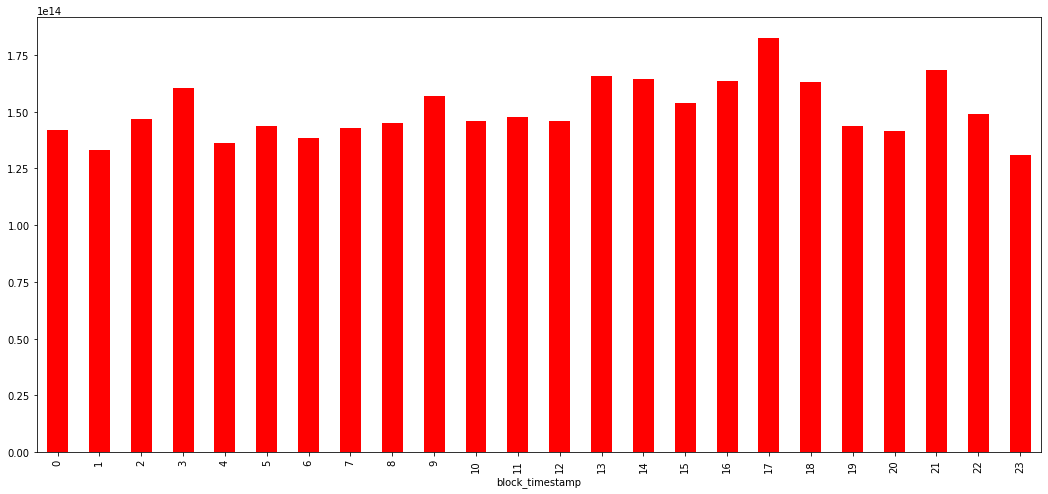

In [ ]:
btc.groupby(btc['block_timestamp'].dt.hour)['avg_out_val'].sum().plot(kind='bar', figsize=(18, 8), color='red')

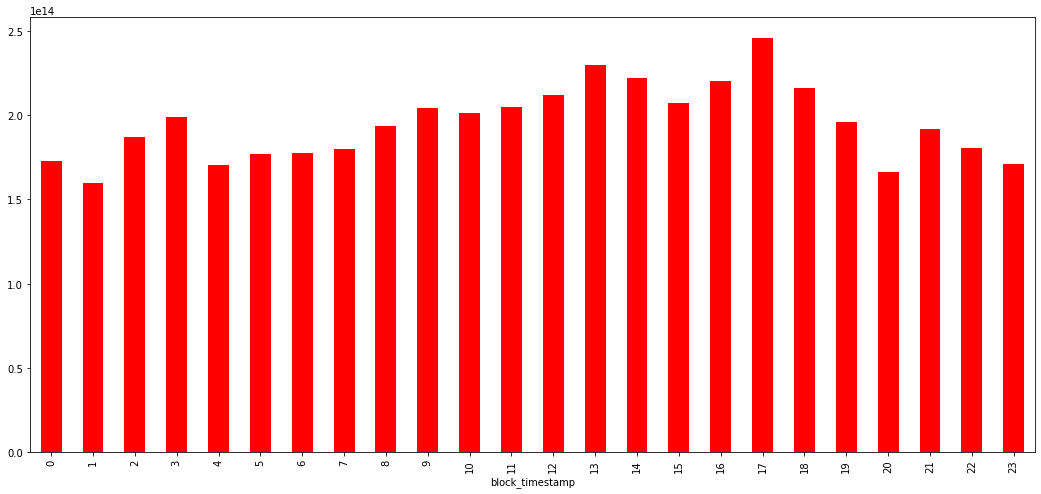

In [ ]:
btc.groupby(btc['block_timestamp'].dt.hour)['avg_in_val'].sum().plot(kind='bar', figsize=(18, 8), color='red')

##Conclusión

En los gráficos se aprecia que el mayor flujo de transacciones se dio entre los dias 19 y 28 de Mayo, siendo el 19 y 20 donde se cobro más por concepto de comisión en la red. El volumen del valor transados en la red durante el 19 y 28 de Mayo, fue producto de la prohibición de China a las instituciones financieras del país brindar servicios relacionados con monedas digitales lo que provocó que Bitcoin perdiera alrededor de un 30% de su valor

Luego se evidencia una constante que ha sido en el comercio de bitcoin, y es que se registra los lunes y en el comienzo de los fines de semana, viernes y/o sabado, el mayor flujo de transacciones, y el mes de Mayo no fue la excepción.

En lo que respecta a las horas del día se debe tener en consideración que la marca de tiempo es la del bloque validado en la red, y no propia de la transacción, sin embargo se "mina" un bloque cada 10 minutos aproximadamente. Los gráficos señalan las 17 horas del dia cuando hay más salidas y entradas de transacciones en la red, pero siendo la mayor parte del día estable durante Mayo, 2021.

In [ ]:
total = btc['input_value'].sum() * 0.000000001
total_fee = btc["fee"].sum() * 0.000000001
fee_input = total_fee * 100 / total_satoshis

print(f"De un total de {total} BTC transferidos durante el mes de Mayo, {total_fee} BTC correspondieron para comisión en transacciones.")
print(f"La pequeña cifra de {fee_input}% del total de BTC en movimiento durante Mayo, 2021")

De un total de 6165792.047732811 BTC transferidos durante el mes de Mayo, 262.689460368 BTC correspondieron para comisión en transacciones.
La pequeña cifra de 0.004260433344724821% del total de BTC en movimiento durante Mayo, 2021


In [ ]:
avg_fee_per_byte = btc['fees_per_byte'].mean()

print(f'Durante el mes de Mayo, se cobro en promedio {avg_fee_per_byte} satoshis por byte procesado en la red')
print("(1 satoshi = 0.000000001 Bitcoin)")

Durante el mes de Mayo, se cobro en promedio 57.86701206800279 satoshis por byte procesado en la red
(1 satoshi = 0.000000001 Bitcoin)
